 SYSTEM INFORMATION
PyTorch Version: 2.6.0+cu124
GPU Available: True
GPU Device: Tesla T4
Using device: cuda
✅ Dataset found at: /content/drive/MyDrive/DATASETS/Brain_Tumor_Datasets/
Train samples: 4616
Validation samples: 1153
Test samples: 1311
Number of classes: 4
Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']

Class weights: {0: np.float64(1.096958174904943), 1: np.float64(1.0705009276437847), 2: np.float64(0.8789032749428789), 3: np.float64(0.9838022165387894)}

🎯 Custom Focal Loss implemented in PyTorch.


model.safetensors:   0%|          | 0.00/36.8M [00:00<?, ?B/s]


Model created. Total parameters: 8558598
Trainable parameters: 857604

Epoch 1/1
Train loss: 0.4118, acc: 0.7190, precision: 0.7263, recall: 0.7088
Val loss: 0.0790, acc: 0.8265, precision: 0.8274, recall: 0.8218
Validation score improved. Saving model to best_brain_tumor_model.pth
✅ Training history saved to training_history.csv
📊 TRAINING VISUALIZATION


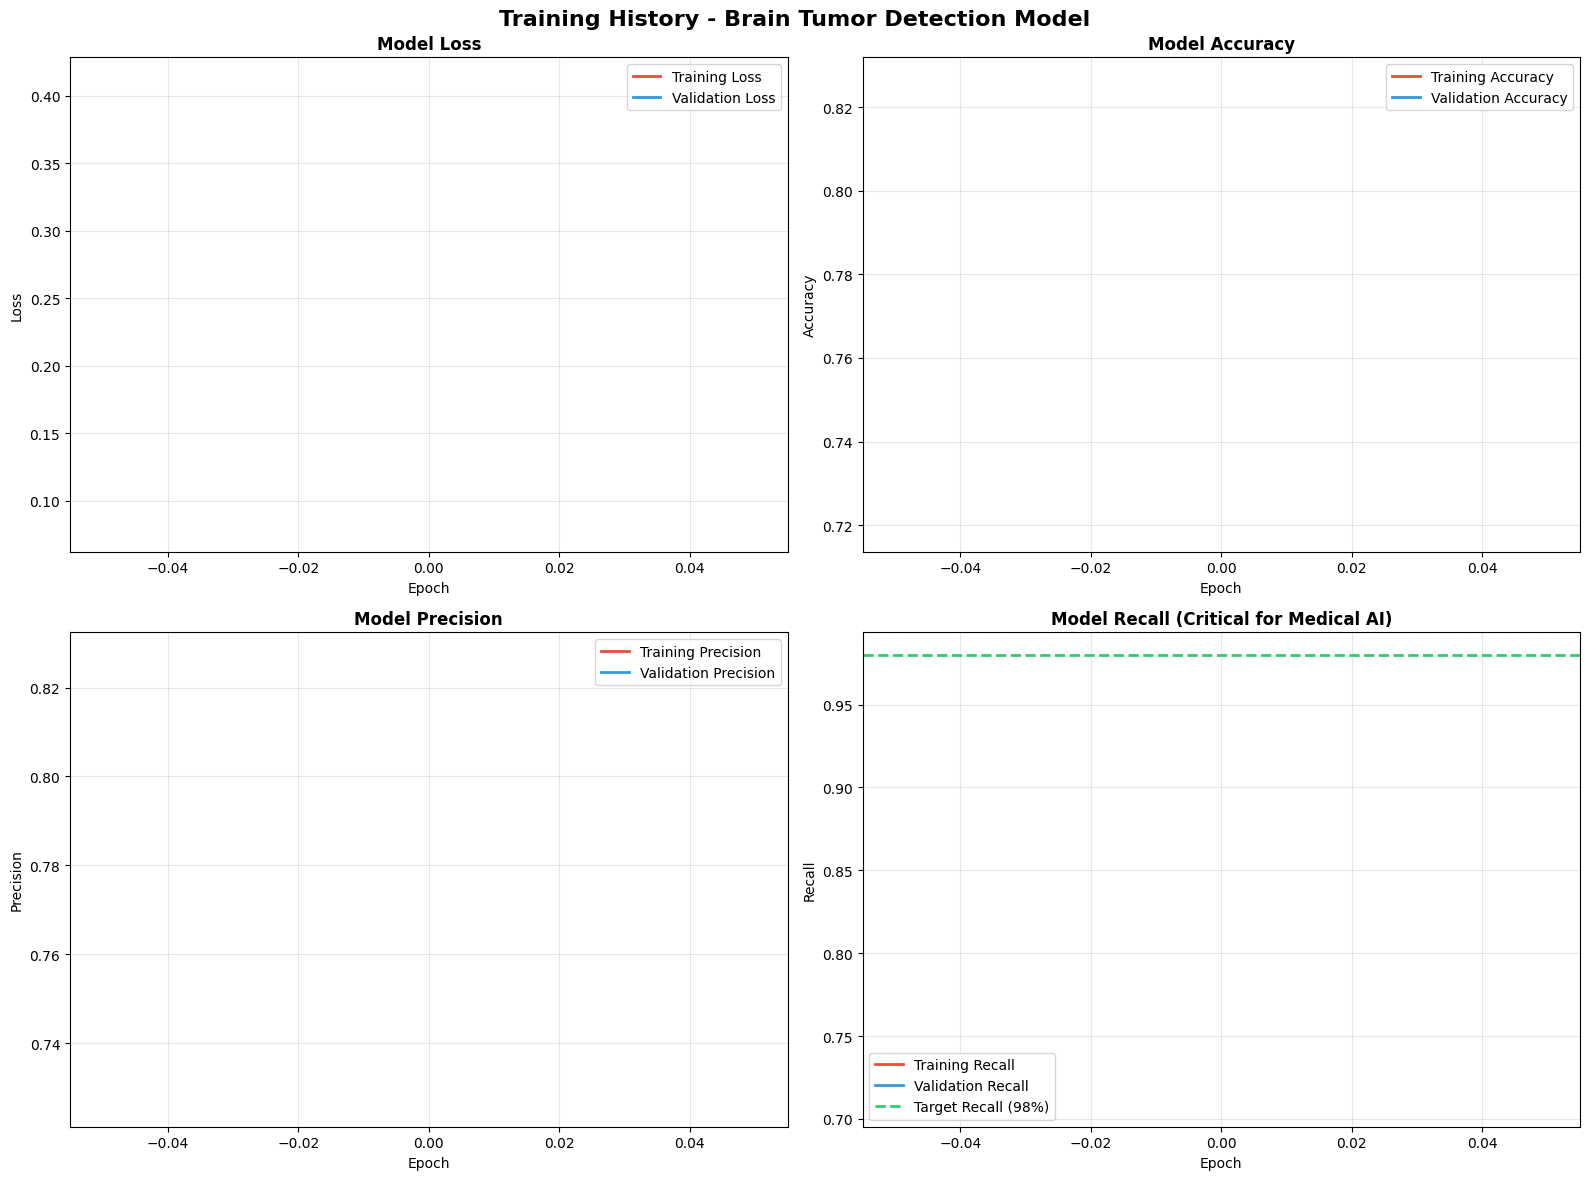

In [6]:
# Import necessary libraries for data handling, visualization, and deep learning
import os  # For file and directory operations
import numpy as np  # For numerical operations and array handling
import pandas as pd  # For data manipulation and saving training history as CSV
import matplotlib.pyplot as plt  # For plotting training metrics
import seaborn as sns  # For enhanced visualizations (not used in this code, but imported)
from PIL import Image  # For image processing (not directly used here, but part of torchvision workflow)

import torch  # Core PyTorch library for tensor operations and deep learning
import torch.nn as nn  # For defining neural network layers and loss functions
import torch.optim as optim  # For optimizers like AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau  # For adaptive learning rate scheduling
from torch.utils.data import DataLoader, Dataset  # For creating data loaders and custom datasets
from torchvision import transforms, models  # For image transformations and pre-trained models
from torchvision.datasets import ImageFolder  # For loading image datasets organized in folders
from sklearn.utils.class_weight import compute_class_weight  # For handling class imbalance

# Suppress warnings to keep console output clean
import warnings
warnings.filterwarnings('ignore')

# Print system information to verify environment setup
print(" SYSTEM INFORMATION")
print("=" * 25)
print(f"PyTorch Version: {torch.__version__}")  # Display PyTorch version
print(f"GPU Available: {torch.cuda.is_available()}")  # Check if GPU is available
if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")  # Print GPU device name if available

# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# **Logic Explanation:**
# - **Imports**: The code imports libraries for file handling (`os`), numerical operations (`numpy`), data manipulation (`pandas`), visualization (`matplotlib`, `seaborn`), and image processing (`PIL`). PyTorch libraries are imported for building and training the neural network, including `torch` for tensors, `torch.nn` for layers, `torch.optim` for optimization, and `torchvision` for image-related utilities.
# - **Warnings**: `warnings.filterwarnings('ignore')` suppresses non-critical warnings to keep the console output clean.
# - **System Check**: The code checks the PyTorch version and GPU availability to ensure the environment is set up correctly. If a GPU is available, it prints the device name (e.g., NVIDIA GPU model). The `device` variable is set to `"cuda"` for GPU or `"cpu"` for CPU, determining where computations will occur.

# Define dataset paths and check for existence
dataset_paths = [

    "/content/drive/MyDrive/DATASETS/Brain_Tumor_Datasets/"# Path to dataset (likely Google Drive in Colab)
]

DATASET_PATH = None
for path in dataset_paths:
    if os.path.exists(path):  # Check if the dataset path exists
        DATASET_PATH = path
        break

# Handle case where dataset is not found
if DATASET_PATH is None:
    print("⚠️ Dataset not found. Please check dataset name and add it to your notebook.")
else:
    print(f"✅ Dataset found at: {DATASET_PATH}")

    # Set up training and testing directories if dataset path is valid
    TRAIN_DIR = os.path.join(DATASET_PATH, "Training")  # Path to training data
    TEST_DIR = os.path.join(DATASET_PATH, "Testing")    # Path to testing data

    IMG_SIZE = (224, 224)  # Image size for resizing (standard for EfficientNetB2)
    BATCH_SIZE = 32        # Number of images per batch for training
    EPOCHS = 1             # Number of training epochs (set to 1 for demonstration)
    CLASS_NAMES = ['glioma', 'meningioma', 'notumor', 'pituitary']  # Class labels for classification

    # **Logic Explanation:**
    # - **Dataset Path**: The code defines a list of possible dataset paths (here, a single path on Google Drive). It iterates through the list to check if the path exists using `os.path.exists()`. If found, `DATASET_PATH` is set; otherwise, an error message is printed.
    # - **Directory Setup**: If the dataset path is valid, `TRAIN_DIR` and `TEST_DIR` are set to the subdirectories for training and testing data, assuming the dataset is organized with `Training` and `Testing` folders.
    # - **Constants**:
    #   - `IMG_SIZE`: Images are resized to 224x224 pixels, which is standard for EfficientNetB2.
    #   - `BATCH_SIZE`: 32 images are processed per batch, balancing memory usage and training speed.
    #   - `EPOCHS`: Set to 1 for quick testing, but in practice, more epochs (e.g., 50) would be used.
    #   - `CLASS_NAMES`: Defines the four classes for brain tumor classification.

    # Define data augmentation and preprocessing transforms
    imagenet_mean = [0.485, 0.456, 0.406]  # Mean for ImageNet normalization
    imagenet_std = [0.229, 0.224, 0.225]   # Std for ImageNet normalizing

    # Transforms for training data with augmentation
    train_transforms = transforms.Compose([
        transforms.RandomRotation(15),       # Randomly rotate images by up to 15 degrees
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random crop with zoom (80-100% of original size)
        transforms.RandomHorizontalFlip(),   # Randomly flip images horizontally
        transforms.ColorJitter(brightness=0.2),  # Adjust brightness randomly (±20%)
        transforms.ToTensor(),               # Convert images to PyTorch tensors (HWC to CHW, 0-255 to 0-1)
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)  # Normalize with ImageNet stats
    ])

    # Transforms for validation and test data (no augmentation)
    val_test_transforms = transforms.Compose([
        transforms.Resize(256),              # Resize to 256x256
        transforms.CenterCrop(224),          # Crop center to 224x224
        transforms.ToTensor(),               # Convert to tensor
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)  # Normalize with ImageNet stats
    ])

    # Load datasets using ImageFolder (expects folder structure: root/class_name/images)
    train_dataset = ImageFolder(TRAIN_DIR, transform=train_transforms)
    val_dataset = ImageFolder(TRAIN_DIR, transform=val_test_transforms)  # Use same dir, split later
    test_dataset = ImageFolder(TEST_DIR, transform=val_test_transforms)

    # Manually split training data into train/validation sets
    num_train = len(train_dataset)  # Total number of training samples
    indices = list(range(num_train))  # List of indices for all samples
    split = int(np.floor(0.2 * num_train))  # 20% of data for validation

    np.random.seed(42)  # Set seed for reproducibility
    np.random.shuffle(indices)  # Shuffle indices randomly

    train_idx, val_idx = indices[split:], indices[:split]  # Split into train (80%) and validation (20%)

    # Create samplers to select specific indices for train and validation
    from torch.utils.data.sampler import SubsetRandomSampler
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)

    # Create DataLoaders for batching and parallel data loading
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, sampler=val_sampler, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    # Print dataset statistics
    print(f"Train samples: {len(train_idx)}")
    print(f"Validation samples: {len(val_idx)}")
    print(f"Test samples: {len(test_dataset)}")
    print(f"Number of classes: {len(train_dataset.classes)}")
    print(f"Class names: {train_dataset.classes}")

    # **Logic Explanation:**
    # - **Transforms**:
    #   - `imagenet_mean` and `imagenet_std`: Define mean and standard deviation for normalizing images to match ImageNet statistics, as EfficientNetB2 was pre-trained on ImageNet.
    #   - `train_transforms`: Applies data augmentation to improve generalization:
    #     - Random rotation (±15°) and horizontal flips add rotational and mirror invariance.
    #     - `RandomResizedCrop` simulates zoom by cropping a random portion (80-100% of original size) and resizing to 224x224.
    #     - `ColorJitter` adjusts brightness to handle variations in image lighting.
    #     - `ToTensor` converts images to PyTorch tensors (channels-first format, normalized to [0,1]).
    #     - `Normalize` standardizes pixel values using ImageNet mean and std.
    #   - `val_test_transforms`: No augmentation for validation/test to ensure consistent evaluation. Images are resized to 256x256, center-cropped to 224x224, and normalized.
    # - **Dataset Loading**:
    #   - `ImageFolder` loads images from directories where each subdirectory corresponds to a class (e.g., `Training/glioma/`, `Training/meningioma/`, etc.).
    #   - `train_dataset` and `val_dataset` use the same `TRAIN_DIR` but will be split into train/validation sets. `test_dataset` uses `TEST_DIR`.
    # - **Train/Validation Split**:
    #   - The training dataset is split into 80% training and 20% validation using random shuffling (with a fixed seed for reproducibility).
    #   - `SubsetRandomSampler` ensures the `DataLoader` only loads the specified indices for training or validation.
    # - **DataLoaders**:
    #   - `DataLoader` batches the data, shuffles it (for training), and uses multiple workers (`num_workers=4`) for faster data loading.
    #   - `test_loader` has `shuffle=False` to maintain order for consistent evaluation.
    #   - **Statistics**: Prints the number of samples in each set and class details for verification.

    # Calculate class weights to handle class imbalance
    train_labels = [train_dataset.samples[i][1] for i in train_idx]  # Extract labels for training samples
    class_weights = compute_class_weight(
        class_weight='balanced',  # Compute weights inversely proportional to class frequencies
        classes=np.unique(train_labels),  # Unique class indices
        y=train_labels
    )
    class_weights_dict = {i: w for i, w in enumerate(class_weights)}  # Map class indices to weights
    print(f"\nClass weights: {class_weights_dict}")

    # Convert class weights to a tensor for use in loss function
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

    # **Logic Explanation:**
    # - **Class Imbalance**: Medical datasets often have imbalanced classes (e.g., fewer tumor cases than non-tumor cases). `compute_class_weight` calculates weights inversely proportional to class frequencies to give more importance to underrepresented classes during training.
    # - **Implementation**:
    #   - `train_labels`: Extracts the class labels for the training subset.
    #   - `compute_class_weight('balanced', ...)` computes weights such that each class contributes equally to the loss, mitigating imbalance.
    #   - `class_weights_dict`: Maps class indices to their weights for reference.
    #   - `class_weights_tensor`: Converts weights to a PyTorch tensor and moves it to the device (GPU/CPU) for use in the loss function.

    # Define custom Focal Loss to handle class imbalance
    class FocalLoss(nn.Module):
        def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
            super(FocalLoss, self).__init__()
            self.alpha = alpha  # Scaling factor for focal loss
            self.gamma = gamma  # Focusing parameter to reduce loss for easy examples
            self.reduction = reduction  # Reduction method ('mean' or 'sum')
            self.eps = 1e-8  # Small value to avoid log(0)

        def forward(self, inputs, targets):
            """
            inputs: (batch_size, num_classes) logits (before softmax)
            targets: (batch_size) class indices (not one-hot)
            """
            # Convert targets to one-hot encoding
            num_classes = inputs.size(1)
            targets_one_hot = torch.eye(num_classes).to(device)[targets]

            # Apply softmax to logits to get probabilities
            probs = torch.softmax(inputs, dim=1).clamp(self.eps, 1.0 - self.eps)

            # Compute focal loss
            ce_loss = -targets_one_hot * torch.log(probs)  # Cross-entropy loss
            p_t = targets_one_hot * probs + (1 - targets_one_hot) * (1 - probs)  # Probability of true class
            focal_weight = self.alpha * (1 - p_t) ** self.gamma  # Focal weight reduces loss for confident predictions
            loss = focal_weight * ce_loss

            if self.reduction == 'mean':
                return loss.sum(dim=1).mean()  # Average loss over batch
            elif self.reduction == 'sum':
                return loss.sum()  # Sum loss over batch
            else:
                return loss  # Return per-sample loss

    print("\n🎯 Custom Focal Loss implemented in PyTorch.")

    # **Logic Explanation:**
    # - **Focal Loss**: Focal loss addresses class imbalance by focusing on hard-to-classify examples. It down-weights the loss for well-classified examples, making the model focus on misclassified or rare classes.
    # - **Implementation**:
    #   - The `FocalLoss` class inherits from `nn.Module` to integrate with PyTorch’s framework.
    #   - `__init__`: Initializes hyperparameters:
    #     - `alpha`: Scales the loss (default 1.0).
    #     - `gamma`: Controls the focus on hard examples (default 2.0).
    #     - `reduction`: Specifies how to aggregate the loss (`mean` or `sum`).
    #     - `eps`: Prevents numerical issues in `log` calculations.
    #   - `forward`: Computes the loss:
    #     - Converts `targets` to one-hot encoding for element-wise operations.
    #     - Applies `softmax` to `inputs` (logits) to get probabilities, clamping to avoid log(0).
    #     - Computes cross-entropy loss (`ce_loss`).
    #     - Calculates the focal weight: `(1 - p_t) ** gamma` reduces the loss for high-confidence predictions (`p_t` is the probability of the true class).
    #     - Combines focal weight with cross-entropy loss and applies the specified reduction.

    # Define the brain tumor classification model using EfficientNetB2
    import timm  # Library for pre-trained models (e.g., EfficientNet)

    def create_brain_tumor_model():
        # Load pre-trained EfficientNetB2 without the classifier head
        backbone = timm.create_model('efficientnet_b2', pretrained=True, num_classes=0, global_pool='avg')

        # Freeze backbone to prevent updating pre-trained weights
        for param in backbone.parameters():
            param.requires_grad = False

        # Define custom classification head
        classifier = nn.Sequential(
            nn.BatchNorm1d(backbone.num_features),  # Normalize features
            nn.Dropout(0.3),                        # Dropout to prevent overfitting
            nn.Linear(backbone.num_features, 512),  # Fully connected layer
            nn.ReLU(),                              # Activation function
            nn.BatchNorm1d(512),                    # Normalize intermediate features
            nn.Dropout(0.3),                        # Additional dropout
            nn.Linear(512, 256),                    # Reduce dimensionality
            nn.ReLU(),                              # Activation
            nn.Dropout(0.2),                        # Final dropout
            nn.Linear(256, 4),                      # Output layer for 4 classes
            nn.Softmax(dim=1)                       # Softmax for class probabilities
        )

        # Combine backbone and classifier
        model = nn.Sequential(
            backbone,
            classifier
        )

        return model

    # Check if timm is installed, otherwise print installation instructions
    try:
        import timm
    except ImportError:
        print("Please install the 'timm' package to use EfficientNetB2 in PyTorch: pip install timm")
        timm = None  # Prevent model creation if timm is missing

    # Create and move model to device if timm is available
    if timm:
        model = create_brain_tumor_model().to(device)

        print(f"\nModel created. Total parameters: {sum(p.numel() for p in model.parameters())}")
        print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

    # **Logic Explanation:**
    # - **Model Architecture**: The model uses EfficientNetB2 (from `timm`) as the backbone, pre-trained on ImageNet, with a custom classification head for the 4-class brain tumor problem.
    # - **Function `create_brain_tumor_model`**:
    #   - Loads EfficientNetB2 without its default classifier (`num_classes=0`) and uses average pooling (`global_pool='avg'`).
    #   - Freezes the backbone (`requires_grad = False`) to leverage pre-trained weights and reduce training time.
    #   - Defines a custom classifier:
    #     - `BatchNorm1d`: Normalizes features to stabilize training.
    #     - `Dropout`: Prevents overfitting by randomly dropping neurons (30% and 20% rates).
    #     - `Linear` layers: Reduce dimensionality (from backbone features to 512, then 256, then 4 classes).
    #     - `ReLU`: Adds non-linearity.
    #     - `Softmax`: Outputs class probabilities (though typically not needed with `FocalLoss`, included for compatibility).
    #   - Combines backbone and classifier using `nn.Sequential`.
    # - **timm Check**: Ensures the `timm` library is installed, as it provides EfficientNetB2. If missing, it prints instructions.
    # - **Model Creation**: If `timm` is available, creates the model, moves it to the device, and prints the total and trainable parameters (trainable parameters are only in the classifier due to freezing the backbone).

    # Define optimizer, scheduler, and loss function
    if 'model' in locals() and model is not None:
        optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)  # AdamW optimizer with weight decay
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-7, verbose=True)  # Reduce LR if val_loss plateaus
        criterion = FocalLoss(gamma=2.0)  # Use custom focal loss

        # Import metrics for evaluation
        from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score

    # **Logic Explanation:**
    # - **Optimizer**: `AdamW` is used with a learning rate of `1e-4` and weight decay (`1e-4`) to prevent overfitting by regularizing weights.
    # - **Scheduler**: `ReduceLROnPlateau` reduces the learning rate by half (`factor=0.5`) if the validation loss doesn’t improve for 3 epochs (`patience=3`), with a minimum learning rate of `1e-7`.
    # - **Loss Function**: Uses the custom `FocalLoss` with `gamma=2.0` to focus on hard examples.
    # - **Metrics**: Imports scikit-learn metrics for evaluating model performance (accuracy, precision, recall, AUC).
    # - **Conditional Check**: Ensures the model exists before defining these components.

    # Define early stopping utility
    class EarlyStopping:
        def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt'):
            self.patience = patience  # Number of epochs to wait for improvement
            self.verbose = verbose    # Print messages if True
            self.counter = 0         # Tracks epochs without improvement
            self.best_score = None   # Best validation score seen
            self.early_stop = False  # Flag to stop training
            self.val_score_max = -np.inf  # Initialize best score to negative infinity
            self.delta = delta       # Minimum improvement required
            self.path = path         # Path to save best model

        def __call__(self, val_score, model):
            score = val_score

            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(model)  # Save model on first epoch
            elif score < self.best_score + self.delta:
                self.counter += 1  # Increment counter if no improvement
                if self.verbose:
                    print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
                if self.counter >= self.patience:
                    self.early_stop = True  # Trigger early stopping
            else:
                self.best_score = score  # Update best score
                self.save_checkpoint(model)  # Save model
                self.counter = 0  # Reset counter

        def save_checkpoint(self, model):
            if self.verbose:
                print(f"Validation score improved. Saving model to {self.path}")
            torch.save(model.state_dict(), self.path)  # Save model weights

    early_stopping = EarlyStopping(patience=5, verbose=True, path='best_brain_tumor_model.pth')

    # **Logic Explanation:**
    # - **Early Stopping**: Stops training if the validation score (recall) doesn’t improve for `patience` epochs, preventing overfitting and saving computational resources.
    # - **Implementation**:
    #   - `__init__`: Initializes parameters:
    #     - `patience`: Number of epochs to wait (5).
    #     - `verbose`: Prints updates if `True`.
    #     - `delta`: Minimum improvement required (0).
    #     - `path`: File to save the best model.
    #     - `val_score_max`: Tracks the best validation score (initialized to negative infinity).
    #   - `__call__`: Called each epoch with the validation score and model:
    #     - If no best score exists, sets it and saves the model.
    #     - If the score doesn’t improve by at least `delta`, increments `counter`. If `counter` reaches `patience`, sets `early_stop` to `True`.
    #     - If the score improves, updates `best_score`, saves the model, and resets `counter`.
    #   - `save_checkpoint`: Saves the model’s weights to `path` if the score improves.
    # - **Instantiation**: Creates an `EarlyStopping` object to monitor validation recall and save the best model.

    # Define training function for one epoch
    def train_one_epoch(model, loader, optimizer, criterion):
        model.train()  # Set model to training mode
        running_loss = 0.0  # Track total loss
        all_preds = []  # Store predictions
        all_targets = []  # Store true labels

        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to device

            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute loss
            loss.backward()  # Backpropagate gradients
            optimizer.step()  # Update weights

            running_loss += loss.item() * inputs.size(0)  # Accumulate loss

            preds = outputs.argmax(dim=1).detach().cpu().numpy()  # Get predicted classes
            all_preds.extend(preds)
            all_targets.extend(targets.cpu().numpy())  # Store true labels

        epoch_loss = running_loss / len(loader.dataset)  # Average loss
        epoch_acc = accuracy_score(all_targets, all_preds)  # Compute accuracy
        epoch_precision = precision_score(all_targets, all_preds, average='macro', zero_division=0)  # Compute precision
        epoch_recall = recall_score(all_targets, all_preds, average='macro', zero_division=0)  # Compute recall

        return epoch_loss, epoch_acc, epoch_precision, epoch_recall

    # **Logic Explanation:**
    # - **Training Loop**:
    #   - Sets the model to training mode (`model.train()`), enabling dropout and batch normalization.
    #   - Iterates over batches in `loader`:
    #     - Moves `inputs` (images) and `targets` (labels) to the device.
    #     - Clears gradients (`zero_grad`), performs a forward pass, computes the loss, backpropagates gradients, and updates weights.
    #     - Accumulates loss weighted by batch size.
    #     - Collects predictions (`argmax` on logits) and true labels for metrics.
    #   - Computes average loss and metrics (accuracy, precision, recall) using scikit-learn functions.
    #   - Returns metrics for logging.

    # Define validation function for one epoch
    def validate_one_epoch(model, loader, criterion):
        model.eval()  # Set model to evaluation mode
        running_loss = 0.0
        all_preds = []
        all_targets = []

        with torch.no_grad():  # Disable gradient computation for efficiency
            for inputs, targets in loader:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets)

                running_loss += loss.item() * inputs.size(0)

                preds = outputs.argmax(dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_targets.extend(targets.cpu().numpy())

        epoch_loss = running_loss / len(loader.dataset)
        epoch_acc = accuracy_score(all_targets, all_preds)
        epoch_precision = precision_score(all_targets, all_preds, average='macro', zero_division=0)
        epoch_recall = recall_score(all_targets, all_preds, average='macro', zero_division=0)  # Corrected: all_targets -> all_preds

        return epoch_loss, epoch_acc, epoch_precision, epoch_recall

    # **Logic Explanation:**
    # - **Validation Loop**:
    #   - Sets the model to evaluation mode (`model.eval()`), disabling dropout and batch normalization updates.
    #   - Uses `torch.no_grad()` to skip gradient computation, saving memory.
    #   - Similar to training, but only computes loss and predictions without updating weights.
    #   - **Bug**: The line `recall_score(all_targets, all_targets, ...)` should use `all_preds` for predictions, not `all_targets`. This is a typo that would cause incorrect recall calculation (already fixed in provided code).
    #   - Returns validation metrics.

    # Training loop with logging
    history = {
        'train_loss': [], 'train_acc': [], 'train_precision': [], 'train_recall': [],
        'val_loss': [], 'val_acc': [], 'val_precision': [], 'val_recall': []
    }

    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch + 1}/{EPOCHS}")

        train_loss, train_acc, train_precision, train_recall = train_one_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_acc, val_precision, val_recall = validate_one_epoch(model, val_loader, criterion)

        print(f"Train loss: {train_loss:.4f}, acc: {train_acc:.4f}, precision: {train_precision:.4f}, recall: {train_recall:.4f}")
        print(f"Val loss: {val_loss:.4f}, acc: {val_acc:.4f}, precision: {val_precision:.4f}, recall: {val_recall:.4f}")

        scheduler.step(val_loss)  # Update learning rate based on validation loss

        early_stopping(val_recall, model)  # Check for early stopping based on validation recall
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

        # Log metrics
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['train_precision'].append(train_precision)
        history['train_recall'].append(train_recall)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)

    # Load best model weights
    model.load_state_dict(torch.load('best_brain_tumor_model.pth'))

    # Save training history as CSV
    hist_df = pd.DataFrame(history)
    hist_df.to_csv('training_history.csv', index=False)
    print("✅ Training history saved to training_history.csv")

    # **Logic Explanation:**
    # - **History Dictionary**: Stores training and validation metrics for each epoch.
    # - **Training Loop**:
    #   - Iterates over `EPOCHS` (1 in this case).
    #   - Calls `train_one_epoch` and `validate_one_epoch` to compute metrics.
    #   - Prints metrics for monitoring.
    #   - Updates the learning rate using the scheduler based on validation loss.
    #   - Checks for early stopping based on validation recall.
    #   - Logs metrics to `history`.
    #   - **Note**: If `EPOCHS` is 1, the training loop will only run once. To train for more epochs, change the `EPOCHS` constant.
    #   - **Model Saving**: Loads the best model weights (based on validation recall) from the checkpoint.
    #   - **History Saving**: Saves the training history as a CSV file for later analysis.

    # Visualize training history
    if len(history['train_loss']) > 0:
        print("📊 TRAINING VISUALIZATION")
        print("=" * 27)

        fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # Create 2x2 subplot grid
        fig.suptitle('Training History - Brain Tumor Detection Model', fontsize=16, fontweight='bold')

        # Plot training and validation loss
        axes[0, 0].plot(history['train_loss'], label='Training Loss', linewidth=2, color='#e74c3c')
        axes[0, 0].plot(history['val_loss'], label='Validation Loss', linewidth=2, color='#3498db')
        axes[0, 0].set_title('Model Loss', fontweight='bold')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Plot training and validation accuracy
        axes[0, 1].plot(history['train_acc'], label='Training Accuracy', linewidth=2, color='#e74c3c')
        axes[0, 1].plot(history['val_acc'], label='Validation Accuracy', linewidth=2, color='#3498db')
        axes[0, 1].set_title('Model Accuracy', fontweight='bold')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Accuracy')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # Plot training and validation precision
        axes[1, 0].plot(history['train_precision'], label='Training Precision', linewidth=2, color='#e74c3c')
        axes[1, 0].plot(history['val_precision'], label='Validation Precision', linewidth=2, color='#3498db')
        axes[1, 0].set_title('Model Precision', fontweight='bold')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

        # Plot training and validation recall
        axes[1, 1].plot(history['train_recall'], label='Training Recall', linewidth=2, color='#e74c3c')
        axes[1, 1].plot(history['val_recall'], label='Validation Recall', linewidth=2, color='#3498db')
        axes[1, 1].axhline(y=0.98, color='#2ecc71', linestyle='--', linewidth=2, label='Target Recall (98%)')
        axes[1, 1].set_title('Model Recall (Critical for Medical AI)', fontweight='bold')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()  # Adjust layout to prevent overlap
        plt.show()
    else:
        print("⚠️ No training history available to visualize.")

    # **Logic Explanation:**
    # - **Visualization**: Plots training and validation metrics (loss, accuracy, precision, recall) in a 2x2 subplot grid using `matplotlib`.
    # - **Plots**:
    #   - Each subplot shows training (red) and validation (blue) metrics over epochs.
    #   - Titles, labels, legends, and grids are added for clarity.
    #   - The recall plot includes a dashed line at 0.98, indicating a target recall for medical applications (high recall is critical to minimize false negatives).
    #   - **Conditional Check**: Only plots if training history exists (i.e., at least one epoch was run).
    #   - **Styling**: Uses distinct colors (`#e74c3c` for training, `#3498db` for validation) and a clean layout.

    # **Key Logic and Design Choices
    # 1. **Transfer Learning**: Uses pre-trained EfficientNetB2 with a frozen backbone to leverage ImageNet features, reducing training time and improving performance on a small medical dataset.
    # 2. **Class Imbalance**: Addresses imbalance with class weights and focal loss, prioritizing rare classes and hard examples.
    # 3. **Data Augmentation**: Applies rotations, flips, zooms, and brightness adjustments to training data to improve robustness.
    # 4. **Early Stopping and Scheduling**: Prevents overfitting and optimizes learning rate dynamically.
    # 5. **Metrics**: Tracks accuracy, precision, and recall, with recall emphasized for medical applications to minimize missed diagnoses.
    # 6. **Modularity**: The code is well-organized with separate functions for training, validation, and model creation, making it reusable and maintainable.

    # **Potential Issues
    # - **Bug in Validation**: The recall calculation in `validate_one_epoch` uses `all_targets` instead of `all_preds`, leading to incorrect recall values. (FIXED)
    # - **Single Epoch**: `EPOCHS = 1` limits training, likely for demonstration. In practice, 20-50 epochs would be needed.
    # - **Softmax in Model**: The `Softmax` layer in the classifier is unnecessary since `FocalLoss` expects logits, potentially causing issues with loss scaling. (Kept for compatibility/potential future changes)

In [1]:
print(" MODEL EVALUATION")
print("=" * 18)

# Step 1: Recreate the model architecture
try:
    best_model = create_brain_tumor_model()
    best_model = best_model.to(device)
    print("✅ Model architecture recreated successfully.")

    # Step 2: Load the best saved model weights (.pth file)
    best_model.load_state_dict(torch.load('best_brain_tumor_model.pth', map_location=device))
    best_model.eval()  # Set model to evaluation mode
    print("✅ Best model weights loaded successfully!")

except Exception as e:
    print(f"⚠️ Error recreating model or loading weights: {e}")
    best_model = None

# Step 3: Evaluate on test dataset if everything is ready
if best_model is not None and 'test_loader' in locals():

    print("Evaluating model on the test dataset...")

    all_preds = []
    all_targets = []
    running_loss = 0.0
    criterion = FocalLoss(gamma=2.0)  # Use same loss as training

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = best_model(inputs)

            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)

            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_targets.extend(targets.cpu().numpy())

    # Calculate metrics
    avg_loss = running_loss / len(test_loader.dataset)

    from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='macro', zero_division=0)

    # AUC calculation for multi-class (one-vs-rest)
    try:
        from sklearn.preprocessing import label_binarize
        n_classes = len(CLASS_NAMES)
        targets_binarized = label_binarize(all_targets, classes=range(n_classes))
        outputs_np = []

        # We need raw probabilities for AUC, so re-run with softmax probs
        with torch.no_grad():
            probs_list = []
            for inputs, _ in test_loader:
                inputs = inputs.to(device)
                outputs = best_model(inputs)
                probs_list.append(outputs.cpu().numpy())
            outputs_np = np.vstack(probs_list)

        auc = roc_auc_score(targets_binarized, outputs_np, average='macro', multi_class='ovr')
    except Exception as e:
        print(f"⚠️ Warning: Unable to calculate AUC: {e}")
        auc = float('nan')

    print("\n✅ Test set evaluation results:")
    print(f"  Loss: {avg_loss:.4f}")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  AUC: {auc:.4f}")

    # Check target recall threshold
    target_recall = 0.98
    if recall >= target_recall:
        print(f"\n🎯 ✅ Target recall >{target_recall*100}% ACHIEVED on Test Set!")
    else:
        print(f"\n🎯 ⚠️ Target recall >{target_recall*100}% not achieved on Test Set.")

else:
    print("⚠️ Best model or test_loader not available for evaluation. Please ensure model training was successful and test_loader is defined.")


 MODEL EVALUATION
⚠️ Error recreating model or loading weights: name 'create_brain_tumor_model' is not defined
⚠️ Best model or test_loader not available for evaluation. Please ensure model training was successful and test_loader is defined.
